In [9]:
from dataclasses import dataclass, field
from typing import Optional
import sys
sys.path.append('/scratch/2023-fall-sp-le/langseg')

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cuda.matmul.allow_tf32 = True
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from methods.prompt_engineering import extract_class_embeddings, extract_clip_text_embeddings
BICUBIC = InterpolationMode.BICUBIC

from datasets.coco_stuff import coco_stuff_categories
from datasets.cityscapes import cat_to_label_id as cityscapes_cats
from datasets.utils import get_dataset
from utils.metrics import RunningScore
from utils.plotting import *

from methods.diffusion_patch import *
from methods.diffusion import *
from methods.diffusion_seg import *
from methods.diffusion_utils import *
from methods.text_embeddings import *
from methods.multilabel_classifiers import *
from methods.diffseg import get_semantics, get_pred_mask

from sklearn.metrics import accuracy_score, classification_report

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@dataclass
class SegmentationConfig:
    dir_dataset: str = field(
        default="/sinergia/ozaydin/segment/STEGO-master/data/cocostuff", metadata={"help": "dir dataset"}
    )
    dataset_name: str = field(
        default="voc2012", metadata={"help": "for get_dataset"}
    )
    split: str = field(
        default="train", metadata={"help": "which split to use"}
    )
    resolution: int = field(
        default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
    )
    mask_res: int = field(
        default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
    )
    dense_clip_arch: str = field(
        default="RN50x16", metadata={"help": "not used in cocostuff"}
    )

args = SegmentationConfig()

In [3]:
dataset, categories, palette = get_dataset(
    dir_dataset=args.dir_dataset,
    dataset_name=args.dataset_name,
    split=args.split,
    resolution=args.resolution,
    mask_res=args.mask_res,
    dense_clip_arch=args.dense_clip_arch
)

if args.dataset_name == "coco_stuff":
    label_id_to_cat = categories if not dataset.use_27 else coco_stuff_categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}
elif args.dataset_name == "cityscapes":
    cat_to_label_id = cityscapes_cats
    label_id_to_cat = {i: c for c, i in cat_to_label_id.items()}
elif args.dataset_name == "voc2012" or args.dataset_name == "pascal_context":
    label_id_to_cat = categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}

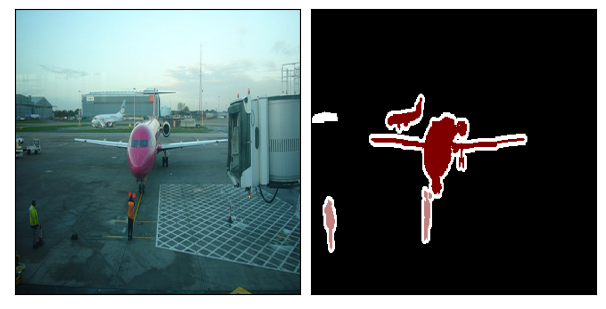

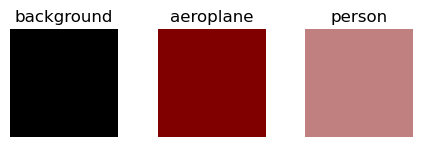

In [4]:
idx = 0
val_img = dataset[idx]["img"].cpu().numpy()
val_gt = dataset[idx]["gt"].cpu().numpy()
lab_ids = sorted(list(np.unique(val_gt)))
lab_ids = np.array(lab_ids[1:])
val_pil_img = render_results(val_img, val_gt, palette)
_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

val_gt = dataset[idx]["gt"].unsqueeze(0)
val_labels = sorted(np.unique(val_gt))
val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
val_labels = [label_id_to_cat[c] for c in val_labels]
val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

In [6]:
# clip_model_id = "openai/clip-vit-large-patch14"
clip_model_id = "facebook/metaclip-h14-fullcc2.5b"
clip_classifier = CLIPMultilabelClassifier(clip_model_id, label_id_to_cat[1:])
clip_classifier.init_text_embeds()

# blip_model_id = "Salesforce/instructblip-flan-t5-xl"
# blip_classifier = BLIPMultilabelClassifier(blip_model_id, labels)

preprocessor_config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [12]:
def get_image_and_labels(idx):
    img_path = dataset[idx]["p_img"]
    image = Image.open(img_path).convert('RGB').resize((1024, 1024))
    val_gt = dataset[idx]["gt"].cpu().numpy()
    val_labels = sorted(np.unique(val_gt))
    val_labels = np.array([l for l in val_labels if l > 0]) - 1
    y_true = np.zeros((20,), dtype=np.int64)
    y_true[val_labels] = 1
    return image, y_true

In [ ]:
y_trues = []
y_preds = {"clip": [], "blip": []}
y_scores = {"clip": [], "blip": []}

pbar = tqdm(range(len(dataset)))
for idx in pbar:
    image, y_true = get_image_and_labels(idx)
    y_trues.append(y_true)

    y_pred, y_score = clip_classifier.forward_v2(image, choice=(4,4), clf_thresh=0.5)
    y_pred, y_score = y_pred.cpu().numpy(), y_score.float().cpu().numpy()
    assert y_pred.sum() > 0
    y_preds["clip"].append(y_pred)
    y_scores["clip"].append(y_score)

    # y_pred, y_score = blip_classifier(image, clf_thresh=0.5)
    # y_pred, y_score = y_pred.cpu().numpy(), y_score.float().cpu().numpy()
    # y_preds["blip"].append(y_pred)
    # y_scores["blip"].append(y_score)

    acc_clip = accuracy_score(np.array(y_trues), np.array(y_preds["clip"]))
    # acc_blip = accuracy_score(np.array(y_trues), np.array(y_preds["blip"]))

    pbar.set_description(
        f"CLIP acc {acc_clip:.3f} | " # 0.61
        # f"BLIP acc {acc_blip:.3f}"
    )

In [ ]:
def get_pred_label_names(y_pred, candidate_labels):
    label_preds = np.array(candidate_labels)[y_pred.astype(bool)]
    assert len(label_preds) > 0
    return label_preds.tolist()
    

In [11]:
print(classification_report(np.array(y_trues), np.array(y_scores["clip"]) > 0.5, target_names=label_id_to_cat[1:]))

              precision    recall  f1-score   support

   aeroplane       0.21      1.00      0.35        88
     bicycle       0.42      0.97      0.58        65
        bird       0.35      0.98      0.51       105
        boat       0.18      1.00      0.30        78
      bottle       0.30      0.91      0.45        87
         bus       0.28      0.99      0.44        78
         car       0.30      0.97      0.46       128
         cat       0.66      1.00      0.80       131
       chair       0.37      0.73      0.49       148
         cow       0.24      1.00      0.39        64
dining table       0.12      1.00      0.22        82
         dog       0.36      1.00      0.53       121
       horse       0.29      0.99      0.44        68
   motorbike       0.39      0.99      0.56        81
      person       0.71      0.84      0.77       442
potted plant       0.12      0.95      0.21        82
       sheep       0.18      1.00      0.30        63
        sofa       0.23    

(array([17349.,  4152.,  1871.,  1055.,   712.,   480.,   404.,   381.,
          397.,  2479.]),
 array([4.7135754e-07, 1.0000041e-01, 2.0000036e-01, 3.0000028e-01,
        4.0000024e-01, 5.0000018e-01, 6.0000014e-01, 7.0000005e-01,
        8.0000001e-01, 8.9999992e-01, 9.9999988e-01], dtype=float32),
 <BarContainer object of 10 artists>)

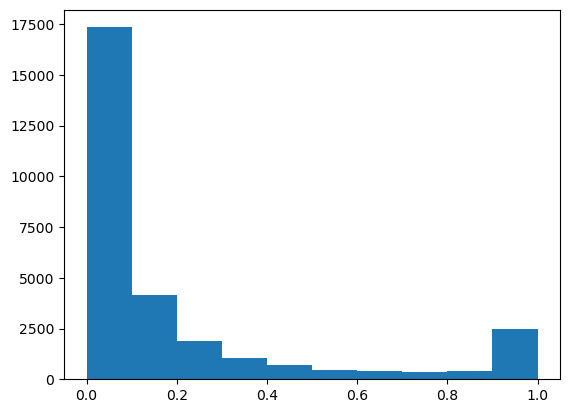

In [16]:
plt.hist(np.array(y_scores["clip"]).flatten())

In [22]:
# multilabel_confusion_matrix(np.array(y_trues), np.array(y_preds))
# accuracy_score(np.array(y_trues), np.array(y_preds))
print(classification_report(np.array(y_trues), np.array(y_scores["clip"]) > 0.5, target_names=label_id_to_cat[1:]))

              precision    recall  f1-score   support

   aeroplane       0.98      1.00      0.99        88
     bicycle       0.89      0.97      0.93        65
        bird       1.00      0.98      0.99       105
        boat       0.81      0.99      0.89        78
      bottle       0.87      0.61      0.72        87
         bus       0.95      0.95      0.95        78
         car       0.92      0.64      0.76       128
         cat       1.00      0.98      0.99       131
       chair       0.87      0.26      0.40       148
         cow       0.97      0.92      0.94        64
dining table       0.75      0.88      0.81        82
         dog       1.00      0.95      0.97       121
       horse       0.85      0.99      0.91        68
   motorbike       0.98      0.98      0.98        81
      person       0.99      0.21      0.35       442
potted plant       0.83      0.63      0.72        82
       sheep       0.90      1.00      0.95        63
        sofa       0.75    

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(classification_report(np.array(y_trues), np.array(y_scores["blip"]) > 0.5, target_names=label_id_to_cat[1:]))

              precision    recall  f1-score   support

   aeroplane       1.00      1.00      1.00        88
     bicycle       0.69      0.95      0.80        65
        bird       0.71      0.99      0.83       105
        boat       0.89      0.99      0.93        78
      bottle       0.58      0.86      0.69        87
         bus       0.91      0.94      0.92        78
         car       0.72      0.85      0.78       128
         cat       0.96      1.00      0.98       131
       chair       0.42      0.93      0.58       148
         cow       0.90      0.97      0.93        64
dining table       0.64      0.95      0.77        82
         dog       0.92      0.98      0.95       121
       horse       0.90      0.97      0.94        68
   motorbike       0.88      0.96      0.92        81
      person       0.77      0.96      0.86       442
potted plant       0.34      0.99      0.51        82
       sheep       0.97      0.92      0.94        63
        sofa       0.66    

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
np.where((np.array(y_trues) != np.array(y_preds["blip"])).sum(axis=-1) > 0)

(array([   4,    5,    8,    9,   12,   13,   15,   18,   19,   21,   24,
          26,   27,   28,   31,   32,   33,   34,   35,   36,   37,   41,
          42,   43,   44,   45,   55,   59,   61,   63,   64,   65,   69,
          73,   74,   75,   76,   80,   81,   82,   83,   84,   85,   86,
          90,   91,   92,  100,  101,  102,  104,  106,  107,  109,  113,
         114,  115,  116,  117,  118,  122,  123,  127,  128,  129,  133,
         134,  139,  142,  143,  146,  149,  152,  155,  156,  157,  160,
         164,  167,  168,  171,  172,  173,  174,  175,  179,  180,  185,
         186,  187,  188,  190,  191,  193,  194,  196,  197,  198,  199,
         200,  204,  205,  206,  208,  209,  210,  211,  212,  213,  214,
         219,  224,  225,  231,  232,  233,  237,  238,  243,  247,  248,
         252,  253,  255,  258,  260,  261,  265,  268,  269,  270,  272,
         278,  279,  281,  282,  283,  286,  287,  288,  289,  291,  295,
         297,  299,  300,  302,  303, 

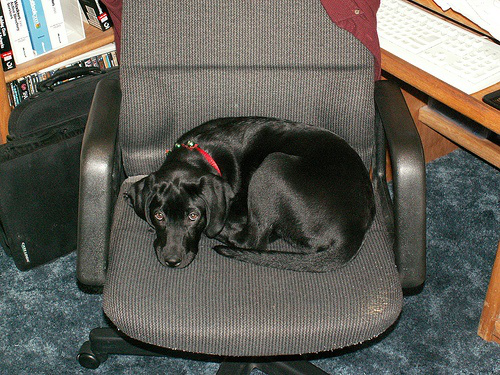

In [127]:
idx = 2
image = Image.open(dataset[idx]["p_img"])
image

In [128]:
list(zip(label_id_to_cat[1:], np.array(y_trues)[idx]))

[('aeroplane', 0),
 ('bicycle', 0),
 ('bird', 0),
 ('boat', 0),
 ('bottle', 0),
 ('bus', 0),
 ('car', 0),
 ('cat', 0),
 ('chair', 1),
 ('cow', 0),
 ('dining table', 0),
 ('dog', 1),
 ('horse', 0),
 ('motorbike', 0),
 ('person', 0),
 ('potted plant', 0),
 ('sheep', 0),
 ('sofa', 0),
 ('train', 0),
 ('tv/monitor', 0)]

In [129]:
list(zip(label_id_to_cat[1:], np.array(y_preds["blip"])[idx]))

[('aeroplane', 0),
 ('bicycle', 0),
 ('bird', 0),
 ('boat', 0),
 ('bottle', 0),
 ('bus', 0),
 ('car', 0),
 ('cat', 0),
 ('chair', 1),
 ('cow', 0),
 ('dining table', 0),
 ('dog', 1),
 ('horse', 0),
 ('motorbike', 0),
 ('person', 1),
 ('potted plant', 0),
 ('sheep', 0),
 ('sofa', 0),
 ('train', 0),
 ('tv/monitor', 0)]

In [79]:
label_id_to_cat[1:]

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'dining table',
 'dog',
 'horse',
 'motorbike',
 'person',
 'potted plant',
 'sheep',
 'sofa',
 'train',
 'tv/monitor']

In [32]:
processor = blip_classifier.blip_processor
blip2 = blip_classifier.blip_model

In [110]:
prompt = "Can you describe this image in detail?"
inputs = processor(images=image, text=prompt, return_tensors="pt", padding=True).to("cuda", blip2.dtype)
# inputs = processor(images, text=prompts, return_tensors="pt", padding=True).to("cuda", blip2.dtype)
outputs = blip2.generate(
    **inputs,
    num_beams=5,
    max_new_tokens=256,
    min_length=1,
    top_p=0.9,
    repetition_penalty=1.5,
    length_penalty=1.0,
    temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)
print(generated_text)

['The image depicts a busy city street with a man riding a bicycle down the street. There is a circular bike rack located in the middle of the street, and several cars can be seen driving along the street. There is also a person on a bike near the center of the street, while a car can be seen closer to the right side of the image. There is also a bicycle parked in the middle of the street, and a car can be seen closer to the left side of the image. Overall, the scene offers a glimpse of a busy city street with a man riding a bicycle down the street.']


In [112]:
captions = []

In [113]:
pbar = tqdm(range(len(dataset)))
for idx in pbar:
    image, y_true = get_image_and_labels(idx)
    prompt = "Can you describe this image in detail?"
    inputs = processor(images=image, text=prompt, return_tensors="pt", padding=True).to("cuda", blip2.dtype)
    # inputs = processor(images, text=prompts, return_tensors="pt", padding=True).to("cuda", blip2.dtype)
    outputs = blip2.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
    )
    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)
    captions.append(generated_text)

100%|██████████| 1464/1464 [2:16:10<00:00,  5.58s/it] 


In [119]:
import pickle

# Save the list as a pickle file
with open("captions.pkl", 'wb') as file:
    pickle.dump([c[0] for c in captions], file)

print(f"The list has been saved as captions.pkl")

The list has been saved as captions.pkl


In [115]:
captions[0]

['The image depicts a pink airplane parked on the tarmac at an airport. A man is standing next to the plane, preparing it for take-off. There are several other vehicles in the background, including a truck and a car. There is also a person standing near the front of the plane, preparing it for take-off.']

In [11]:
# list(zip(label_id_to_cat[1:], np.array(y_trues)[114]))

In [12]:
# list(zip(label_id_to_cat[1:], (np.array(y_scores)[114] > 0.5).astype(int)))